In [3]:
from IPython.display import Image
# 단어 레벨에서 글자 레벨로 변경하여 RNN 구현

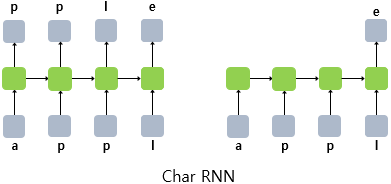

In [4]:
Image('char_rnn1.png')

In [6]:
# 데이터에 대한 이해와 전처리
import numpy as np
import urllib.request
from tensorflow.keras.utils import to_categorical

In [7]:
urllib.request.urlretrieve("http://www.gutenberg.org/files/11/11-0.txt", filename="11-0.txt")
f = open('11-0.txt','rb')
lines=[]
for line in f:
    line=line.strip() # strip()을 통해 \r, \n 제거
    line=line.lower()
    line=line.decode('ascii','ignore') # \xe2\x80\x99 등과 같은 바이트 열 제거
    if len(line) > 0:
        lines.append(line)
f.close()

In [8]:
lines[:5]

['the project gutenberg ebook of alices adventures in wonderland, by lewis carroll',
 'this ebook is for the use of anyone anywhere in the united states and',
 'most other parts of the world at no cost and with almost no restrictions',
 'whatsoever. you may copy it, give it away or re-use it under the terms',
 'of the project gutenberg license included with this ebook or online at']

In [9]:
# 하나의 문자열로 통합
text = ' '.join(lines)
print('문자열이 길이 또는 총 글자의 개수: %d' % len(text))

문자열이 길이 또는 총 글자의 개수: 159484


In [10]:
print(text[:200])

the project gutenberg ebook of alices adventures in wonderland, by lewis carroll this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with


In [12]:
# 글자 집합 만들기
char_vocab = sorted(list(set(text)))
vocab_size = len(char_vocab)
print('글자 집합의 크기 : {}'.format(vocab_size))

글자 집합의 크기 : 56


In [13]:
# 방대한 데이터라도, 영어 단어를 표현하기 위해서 글자 집합에 포함되는 글자는 26개의 알파뱃,
# 대문자라도 52개의 알파뱃으로 표현 가능

In [14]:
char_to_index = dict((c,i) for i, c in enumerate(char_vocab)) # 글자에 고유한 정수 인덱스 부여
print(char_to_index)

{' ': 0, '!': 1, '"': 2, '#': 3, '$': 4, '%': 5, "'": 6, '(': 7, ')': 8, '*': 9, ',': 10, '-': 11, '.': 12, '/': 13, '0': 14, '1': 15, '2': 16, '3': 17, '4': 18, '5': 19, '6': 20, '7': 21, '8': 22, '9': 23, ':': 24, ';': 25, '?': 26, '[': 27, ']': 28, '_': 29, 'a': 30, 'b': 31, 'c': 32, 'd': 33, 'e': 34, 'f': 35, 'g': 36, 'h': 37, 'i': 38, 'j': 39, 'k': 40, 'l': 41, 'm': 42, 'n': 43, 'o': 44, 'p': 45, 'q': 46, 'r': 47, 's': 48, 't': 49, 'u': 50, 'v': 51, 'w': 52, 'x': 53, 'y': 54, 'z': 55}


In [15]:
# 인덱스로부터 글자를 리턴하는 index_to_char
index_to_char = {}
for key, value in char_to_index.items():
    index_to_char[value] = key

In [16]:
# 훈련데이터 구성
seq_length = 60 # 문장의 길이 60
n_samples = int(np.floor((len(text) -1)/seq_length)) # 문자열을 60등분
print('문장 샘플의 수 : {}'.format(n_samples))

문장 샘플의 수 : 2658


In [17]:
train_X=[]
train_y=[]

for i in range(n_samples):
    X_sample = text[i * seq_length: (i+1) * seq_length] 
    # 0:60 -> 60:120 -> 120:180로 loop를 돌면저 문장 샘플을 1개씩 가져온다.
    X_encoded = [char_to_index[c] for c in X_sample] # 하나의 문장 생플에 대해서 정수 인코딩
    train_X.append(X_encoded)
    
    y_sample = text[i * seq_length + 1: (i+1) * seq_length + 1] # 오른쪽으로 1칸 쉬프트
    y_encoded = [char_to_index[c] for c in y_sample]
    train_y.append(y_encoded)

In [18]:
print(train_X[0])

[49, 37, 34, 0, 45, 47, 44, 39, 34, 32, 49, 0, 36, 50, 49, 34, 43, 31, 34, 47, 36, 0, 34, 31, 44, 44, 40, 0, 44, 35, 0, 30, 41, 38, 32, 34, 48, 0, 30, 33, 51, 34, 43, 49, 50, 47, 34, 48, 0, 38, 43, 0, 52, 44, 43, 33, 34, 47, 41, 30]


In [19]:
print(train_y[0])

[37, 34, 0, 45, 47, 44, 39, 34, 32, 49, 0, 36, 50, 49, 34, 43, 31, 34, 47, 36, 0, 34, 31, 44, 44, 40, 0, 44, 35, 0, 30, 41, 38, 32, 34, 48, 0, 30, 33, 51, 34, 43, 49, 50, 47, 34, 48, 0, 38, 43, 0, 52, 44, 43, 33, 34, 47, 41, 30, 43]


In [20]:
# 원 핫 인코딩
train_X = to_categorical(train_X)
train_y = to_categorical(train_y)

In [22]:
print('train_X의 크기(shape) : {}'.format(train_X.shape))
print('train_y의 크기(shape) : {}'.format(train_y.shape))

train_X의 크기(shape) : (2658, 60, 56)
train_y의 크기(shape) : (2658, 60, 56)


In [23]:
# 모델 설계
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed

In [25]:
model = Sequential()
model.add(LSTM(256, input_shape=(None, train_X.shape[2]), return_sequences=True))
model.add(LSTM(256, return_sequences=True))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))

In [28]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_X, train_y, epochs=80, verbose=2)

Epoch 1/80
84/84 - 9s - loss: 3.0654 - accuracy: 0.1820
Epoch 2/80
84/84 - 1s - loss: 2.7023 - accuracy: 0.2532
Epoch 3/80
84/84 - 1s - loss: 2.3672 - accuracy: 0.3346
Epoch 4/80
84/84 - 1s - loss: 2.2306 - accuracy: 0.3672
Epoch 5/80
84/84 - 1s - loss: 2.1178 - accuracy: 0.3937
Epoch 6/80
84/84 - 1s - loss: 2.0294 - accuracy: 0.4149
Epoch 7/80
84/84 - 1s - loss: 1.9557 - accuracy: 0.4351
Epoch 8/80
84/84 - 1s - loss: 1.8936 - accuracy: 0.4513
Epoch 9/80
84/84 - 1s - loss: 1.8359 - accuracy: 0.4682
Epoch 10/80
84/84 - 1s - loss: 1.7807 - accuracy: 0.4825
Epoch 11/80
84/84 - 1s - loss: 1.7337 - accuracy: 0.4935
Epoch 12/80
84/84 - 1s - loss: 1.6878 - accuracy: 0.5063
Epoch 13/80
84/84 - 1s - loss: 1.6466 - accuracy: 0.5167
Epoch 14/80
84/84 - 1s - loss: 1.6076 - accuracy: 0.5270
Epoch 15/80
84/84 - 1s - loss: 1.5720 - accuracy: 0.5365
Epoch 16/80
84/84 - 1s - loss: 1.5363 - accuracy: 0.5462
Epoch 17/80
84/84 - 1s - loss: 1.5042 - accuracy: 0.5547
Epoch 18/80
84/84 - 1s - loss: 1.4724 - 

In [31]:
def sentence_generation(model, length):
    ix = [np.random.randint(vocab_size)] # 글자에 대한 랜덤 인덱스 생성
    y_char = [index_to_char[ix[-1]]] # 랜덤 익덱스로부터 글자 생성
    print(ix[-1],'번 글자',y_char[-1],'로 예측을 시작!')
    X = np.zeros((1, length, vocab_size)) # (1, length, 55) 크기의 X 생성. 즉, LSTM의 입력 시퀀스 생성

    for i in range(length):
        X[0][i][ix[-1]] = 1 # X[0][i][예측한 글자의 인덱스] = 1, 즉, 예측 글자를 다음 입력 시퀀스에 추가
        print(index_to_char[ix[-1]], end="")
        ix = np.argmax(model.predict(X[:, :i+1, :])[0], 1)
        y_char.append(index_to_char[ix[-1]])
    return ('').join(y_char)

In [33]:
sentence_generation(model, 100)

31 번 글자 b 로 예측을 시작!
berg literary archive foundation, the manager of the project gutenberg literary archive foundation a

'berg literary archive foundation, the manager of the project gutenberg literary archive foundation af'

In [35]:
# 글자 단위 RNN으로 텍스트 생성
import numpy as np
from tensorflow.keras.utils import to_categorical

In [36]:
text='''
I get on with life as a programmer,
I like to contemplate beer.
But when I start to daydream,
My mind turns straight to wine.

Do I love wine more than beer?

I like to use words about beer.
But when I stop my talking,
My mind turns straight to wine.

I hate bugs and errors.
But I just think back to wine,
And I'm happy once again.

I like to hang out with programming and deep learning.
But when left alone,
My mind turns straight to wine.
'''

In [37]:
tokens = text.split() # \n 제거
text = ' '.join(tokens)
print(text)

I get on with life as a programmer, I like to contemplate beer. But when I start to daydream, My mind turns straight to wine. Do I love wine more than beer? I like to use words about beer. But when I stop my talking, My mind turns straight to wine. I hate bugs and errors. But I just think back to wine, And I'm happy once again. I like to hang out with programming and deep learning. But when left alone, My mind turns straight to wine.


In [38]:
# 중복을 제거한 글자 집합 생성
char_vocab = sorted(list(set(text)))
print(char_vocab)

[' ', "'", ',', '.', '?', 'A', 'B', 'D', 'I', 'M', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']


In [39]:
vocab_size=len(char_vocab)
print('글자 집합의 크기 : {}'.format(vocab_size))

글자 집합의 크기 : 33


In [41]:
char_to_index = dict((c,i) for i, c in enumerate(char_vocab)) # 글자에 고유한 정수 인덱스 부여
print(char_to_index)

{' ': 0, "'": 1, ',': 2, '.': 3, '?': 4, 'A': 5, 'B': 6, 'D': 7, 'I': 8, 'M': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'r': 26, 's': 27, 't': 28, 'u': 29, 'v': 30, 'w': 31, 'y': 32}


In [43]:
# 입력 시퀀스의 길이, 즉, 모든 샘플들의 길이가 10이 되도록 데이터를 구성
# 예측 대상이 되는 글자도 필요하므로, 우선 길이가 11이 되도록 구성
length=11
sequences=[]
for i in range(length, len(text)):
    seq=text[i-length:i]
    sequences.append(seq)
print('총 훈련 샘플의 수 : %d' % len(sequences))

총 훈련 샘플의 수 : 426


In [44]:
sequences[:10]

['I get on wi',
 ' get on wit',
 'get on with',
 'et on with ',
 't on with l',
 ' on with li',
 'on with lif',
 'n with life',
 ' with life ',
 'with life a']

In [45]:
X=[]
for line in sequences: # 전체 데이터에서 문장 샘플을 1개씩 꺼낸다.
    temp_X = [char_to_index[char] for char in line] # 문장 샘플에서 각 글자에 대해서 정수 인코딩을 수행
    X.append(temp_X)

In [46]:
for line in X[:5]:
    print(line)

[8, 0, 16, 14, 28, 0, 24, 23, 0, 31, 18]
[0, 16, 14, 28, 0, 24, 23, 0, 31, 18, 28]
[16, 14, 28, 0, 24, 23, 0, 31, 18, 28, 17]
[14, 28, 0, 24, 23, 0, 31, 18, 28, 17, 0]
[28, 0, 24, 23, 0, 31, 18, 28, 17, 0, 21]


In [47]:
# 모든 샘플 문장에 대해서 맨 마지막 글자를 분리
sequences=np.array(X)
X=sequences[:,:-1]
y=sequences[:,-1]

In [48]:
for line in X[:5]:
    print(line)

[ 8  0 16 14 28  0 24 23  0 31]
[ 0 16 14 28  0 24 23  0 31 18]
[16 14 28  0 24 23  0 31 18 28]
[14 28  0 24 23  0 31 18 28 17]
[28  0 24 23  0 31 18 28 17  0]


In [49]:
print(y[:5])

[18 28 17  0 21]


In [50]:
# X와 y에 대해서 원-핫 인코딩 수행
sequences = [to_categorical(x, num_classes=vocab_size) for x in X] # X에 대한 원-핫 인코딩
X = np.array(sequences)
y = to_categorical(y, num_classes=vocab_size) # y에 대한 원-핫 인코딩

In [51]:
print(X.shape)

(426, 10, 33)


In [52]:
# 모델 설계
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [54]:
model = Sequential()
model.add(LSTM(80, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(vocab_size, activation='softmax'))

In [56]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=100, verbose=2)

Epoch 1/100
14/14 - 2s - loss: 3.4499 - accuracy: 0.1643
Epoch 2/100
14/14 - 0s - loss: 3.2290 - accuracy: 0.1972
Epoch 3/100
14/14 - 0s - loss: 3.0411 - accuracy: 0.1972
Epoch 4/100
14/14 - 0s - loss: 2.9752 - accuracy: 0.1972
Epoch 5/100
14/14 - 0s - loss: 2.9473 - accuracy: 0.1972
Epoch 6/100
14/14 - 0s - loss: 2.9270 - accuracy: 0.1972
Epoch 7/100
14/14 - 0s - loss: 2.9118 - accuracy: 0.1972
Epoch 8/100
14/14 - 0s - loss: 2.8894 - accuracy: 0.1995
Epoch 9/100
14/14 - 0s - loss: 2.8580 - accuracy: 0.1972
Epoch 10/100
14/14 - 0s - loss: 2.8283 - accuracy: 0.1972
Epoch 11/100
14/14 - 0s - loss: 2.7877 - accuracy: 0.2042
Epoch 12/100
14/14 - 0s - loss: 2.7395 - accuracy: 0.2042
Epoch 13/100
14/14 - 0s - loss: 2.6826 - accuracy: 0.2324
Epoch 14/100
14/14 - 0s - loss: 2.6413 - accuracy: 0.2136
Epoch 15/100
14/14 - 0s - loss: 2.5954 - accuracy: 0.2606
Epoch 16/100
14/14 - 0s - loss: 2.5320 - accuracy: 0.2441
Epoch 17/100
14/14 - 0s - loss: 2.5058 - accuracy: 0.2770
Epoch 18/100
14/14 - 0s

In [57]:
def sentence_generation(model, char_to_index, seq_length, seed_text, n):
# 모델, 인덱스 정보, 문장 길이, 초기 시퀀스, 반복 횟수
    init_text = seed_text # 문장 생성에 사용할 초기 시퀀스
    sentence = ''

    for _ in range(n): # n번 반복
        encoded = [char_to_index[char] for char in seed_text] # 현재 시퀀스에 대한 정수 인코딩
        encoded = pad_sequences([encoded], maxlen=seq_length, padding='pre') # 데이터에 대한 패딩
        encoded = to_categorical(encoded, num_classes=len(char_to_index))
        result = model.predict_classes(encoded, verbose=0)
        # 입력한 X(현재 시퀀스)에 대해서 y를 예측하고 y(예측한 글자)를 result에 저장.
        for char, index in char_to_index.items(): # 만약 예측한 글자와 인덱스와 동일한 글자가 있다면
            if index == result: # 해당 글자가 예측 글자이므로 break
                break
        seed_text=seed_text + char # 현재 시퀀스 + 예측 글자를 현재 시퀀스로 변경
        sentence=sentence + char # 예측 글자를 문장에 저장
        # for문이므로 이 작업을 다시 반복

    sentence = init_text + sentence
    return sentence

In [59]:
print(sentence_generation(model, char_to_index, 10, 'I get on w', 80))

C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


I get on with life as a programmer, I like to contemplate beer. But when I start to daydre
